In [1]:
import numpy as np
import seaborn as sns
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader,TensorDataset
import matplotlib.pyplot as plt
iris = sns.load_dataset('iris')


In [2]:
data = torch.tensor(iris[iris.columns[0:4]].values).float()
labels = torch.zeros(len(data),dtype=torch.long )
labels[iris.species=='versicolor'] = 1
labels[iris.species=='virginica'] = 2

In [3]:
train_data,test_data,train_labels,test_labels = \
                                      train_test_split(data,labels,train_size= .8)
train_data =TensorDataset(train_data,train_labels)
test_data = TensorDataset(test_data,test_labels)
train_loader = DataLoader(train_data,shuffle=True,batch_size= 64,drop_last = True)
test_loader = DataLoader(test_data,batch_size=test_data.tensors[0].shape[0])

In [4]:
def createANewmodel(L2lambda):
  ANNiris = nn.Sequential(
      nn.Linear(4,64),
      nn.ReLU(),
      nn.Linear(64,64),
      nn.ReLU(),
      nn.Linear(64,3)
    )
  lossfun = nn.CrossEntropyLoss()
  optimizer = torch.optim.SGD(ANNiris.parameters(),lr = 0.005,weight_decay = L2lambda)
  return ANNiris,lossfun,optimizer

In [5]:
numepochs = 1000
def trainmodel():
  trainAcc =[]
  testAcc = []
  losses = []
  for epochi in range(numepochs):
    batchAcc = []
    batchLoss = []
    for x,y in train_loader:
      yHat = ANNiris(x)
      loss = lossfun(yHat,y)
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      batchAcc.append(100*torch.mean((torch.argmax(yHat,axis=1)==y).float()).item())
      batchLoss.append(loss.item())
    trainAcc.append(np.mean(batchAcc))
    losses.append(np.mean(batchLoss))
    x,y = next(iter(test_loader))
    predlabels = torch.argmax(ANNiris(x),axis=1)
    testAcc.append(100*torch.mean((predlabels==y).float()).item())
  return trainAcc,testAcc ,losses

In [6]:
L2lambda = .01
ANNiris,lossfun,optimizer = createANewmodel(L2lambda)
trainAcc,testAcc,losses = trainmodel()

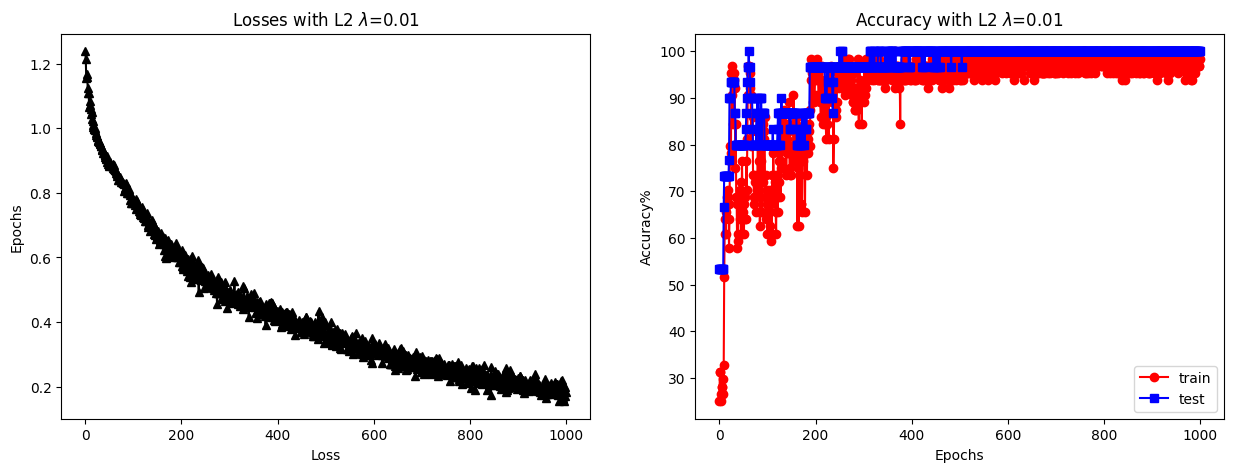

In [8]:
fig,ax = plt.subplots(1,2,figsize = (15,5))
ax[0].plot(losses,'k^-')
ax[0].set_xlabel('Loss')
ax[0].set_ylabel('Epochs')
ax[0].set_title('Losses with L2 $\lambda$='+str(L2lambda))

ax[1].plot(trainAcc,'ro-')
ax[1].plot(testAcc,'bs-')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy%')
ax[1].set_title('Accuracy with L2 $\lambda$='+str(L2lambda))
ax[1].legend(['train','test'])

In [9]:
def smooth(x,k):
  return np.convolve(x,np.ones(k)/k,mode= 'same')

In [11]:
l2lambdas = np.linspace(0,.1,10)
accuracyResultsTrain = np.zeros((numepochs,len(l2lambdas)))
accuracyResultsTest = np.zeros((numepochs,len(l2lambdas)))
for li in range(len(l2lambdas)):
  ANNiris,lossfun,optimizer = createANewmodel(l2lambdas[li])
  trainAcc,testAcc,losses = trainmodel()
  accuracyResultsTrain[:,li] = smooth(trainAcc,10)
  accuracyResultsTest[:,li] = smooth(testAcc,10)

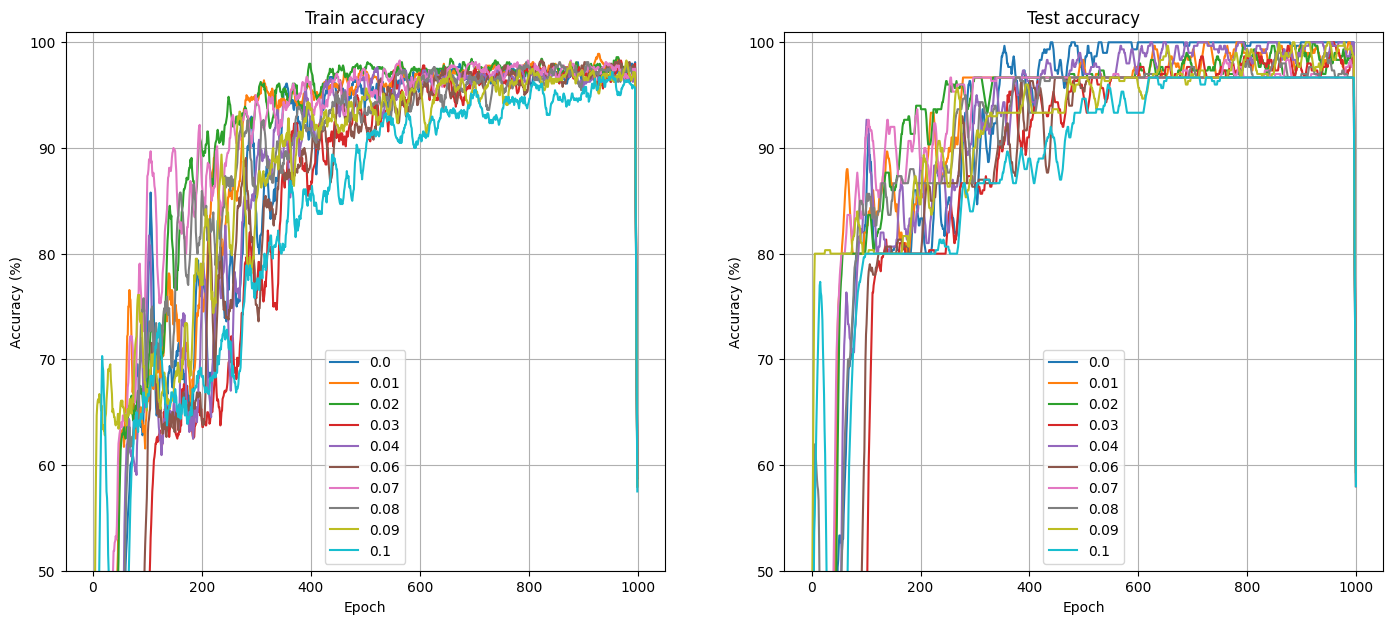

In [13]:
fig,ax = plt.subplots(1,2,figsize=(17,7))
ax[0].plot(accuracyResultsTrain)
ax[0].set_title('Train accuracy')
ax[1].plot(accuracyResultsTest)
ax[1].set_title('Test accuracy')

leglabels = [np.round(i,2) for i in l2lambdas]
for i in range(2):
  ax[i].legend(leglabels)
  ax[i].set_xlabel('Epoch')
  ax[i].set_ylabel('Accuracy (%)')
  ax[i].set_ylim([50,101])
  ax[i].grid()

Text(0, 0.5, 'Accuracy')

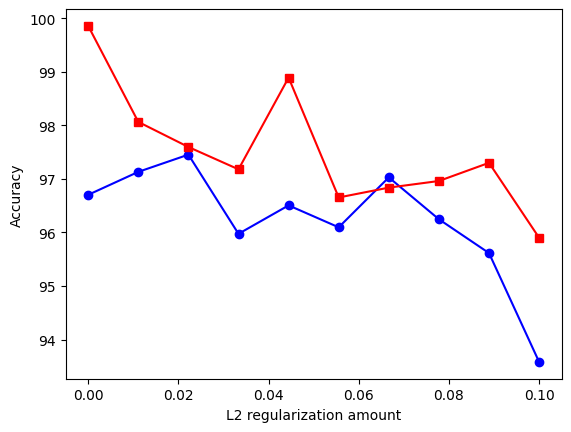

In [14]:
epoch_range = [500,950]
plt.plot(l2lambdas,np.mean(accuracyResultsTrain[epoch_range[0]:epoch_range[1],:],axis = 0),
         'bo-',label= 'Train')
plt.plot(l2lambdas,np.mean(accuracyResultsTest[epoch_range[0]:epoch_range[1],:],axis = 0),
         'rs-',label= 'Test')
plt.xlabel('L2 regularization amount')
plt.ylabel('Accuracy')
